# Exploring Segmentation of Toronto Neighborhoods 

### Coursera Capstone – Aug 2020

**Ameya Sohoni** *ameyasohoni@outlook.com*


### 0. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import folium
import time
import re
from matplotlib import pyplot as plt
import pgeocode
import geopy
from geopy.distance import geodesic

### 1. Downloading list and geojson file for Toronto neighborhoods 

**1.1 Loading list of neighborhoods**

In [3]:
# load list if TO neighborhoods along with crime data from TO police website

crimeurl = "https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.csv?outSR=%7B%22latestWkid%22%3A26717%2C%22wkid%22%3A26717%7D"
crime_df = pd.read_csv(crimeurl)
crime_df = crime_df[['Neighbourhood',
          'Assault_Rate_2019',
          'AutoTheft_Rate_2019',
          'BreakandEnter_Rate_2019',
          'Homicide_Rate_2019',
          'Robbery_Rate_2019',
          'TheftOver_Rate_2019'
         ]]
crime_df.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace=True)

# Calculating Total Crime Rate for major crimes and dropping other columns

crime_df['Total Crime'] = crime_df.iloc[:,1:].sum(axis=1)
crime_df = crime_df[['Neighborhood','Total Crime']]

print(crime_df.head())

print('\nThere are {} neighborhoods'.format(crime_df.shape[0]))

              Neighborhood  Total Crime
0           Yonge-St.Clair        646.5
1  York University Heights       2642.0
2         Lansing-Westgate       1020.9
3       Yorkdale-Glen Park       2877.7
4      Stonegate-Queensway        822.3

There are 140 neighborhoods


**1.2 Loading geojson file for TO neighborhoods**<br>
*geojson courtesy: github user jasonicarter*

In [4]:
# load GeoJSON file containing sectors and plot map of neighborhoods
js = requests.get("https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson").json()

neigh_geo = 'https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson'

m = folium.Map(location=[43.721, -79.4], zoom_start=11, tiles='CartoDB positron')

folium.Choropleth(
    geo_data=neigh_geo,
    name='choropleth',
    fill_color='blue',
    line_color='blue',
    fill_opacity=0.1,
    line_opacity=1.0
).add_to(m)

m

### 2. Creating a base dataframe of TO neighborhoods and loading crime and rent data

**2.1 Marking the centers of each neighborhood**

In [5]:
# Marking centers of each neighborhood to facilitate the analysis of rent data and foursquare places data

from shapely.geometry import shape, Point

# Create a dictionary of polygons for each neighborhood
neigh_dict = {}
for feature in js['features']:
    i = feature['properties']['AREA_NAME'].rsplit(' (')[0]
    neigh_dict[i] = shape(feature['geometry'])

# Create a separate dictionary for centers of each neighborhood
neigh_centers={}
for feature in js['features']:
    j = feature['properties']['AREA_NAME'].rsplit(' (')[0]
    # Saving tuple of lat/lon values
    neigh_centers[j] = (shape(feature['geometry']).centroid.y, shape(feature['geometry']).centroid.x)

**2.2 Creating a base dataframe to store list of neighborhoods and featureset**

In [6]:
# Create a base dataframe to store our featureset
to_neighborhoods = crime_df.copy()

# Adding lat and lon values for neighborhood centers

for i in to_neighborhoods.index:
    neigh = to_neighborhoods.loc[i,'Neighborhood']
    to_neighborhoods.loc[i,'Latitude'] = neigh_centers[neigh][0]
    to_neighborhoods.loc[i,'Longitude'] = neigh_centers[neigh][1]

# Re-arranging df
to_neighborhoods = to_neighborhoods[['Neighborhood','Latitude','Longitude','Total Crime']]
to_neighborhoods.head()

Neighborhood   Latitude  Longitude  Total Crime
0           Yonge-St.Clair  43.687859 -79.397871        646.5
1  York University Heights  43.765738 -79.488883       2642.0
2         Lansing-Westgate  43.754272 -79.424747       1020.9
3       Yorkdale-Glen Park  43.714672 -79.457108       2877.7
4      Stonegate-Queensway  43.635518 -79.501128        822.3

**2.3 Loading rent data and marking lat/lon using geopy**<br>
Since the names of neighborhoods are different for rent data, I looked up the lat/lon values of the neighborhoods and assigned average rent values to neighborhoods in the base data frame (see 2.2). This gives us a good approximation of rent information considering the available data.

**2.3.1 Define function to get lat/lon values**

In [7]:
# Defining a function to get lat/lon values for a neighborhood

def findcoord(series, city_str):
    import geopy
    import time
    geolocator = geopy.geocoders.Nominatim(user_agent = 'city_explorer')
    lats=[]
    lons=[]
    
    for n in series:
        location = None
        cnt = 0
        while location == None and cnt <=3: # Try looking 3 times
            string = n + ", " + city_str
            location = geolocator.geocode(string)
            cnt+=1
        if location == None:
            lats.append(0.0)
            lons.append(0.0)

        else:
            lats.append(location.latitude)
            lons.append(location.longitude)
            
    out = {'Latitude':lats, 'Longitude':lons}
    return(out)     

**2.3.2 Get lat/lon values and add to rent dataframe**

In [8]:
# Importing rent data df

# Data copied from zumper.com, link available in references
to_rent = pd.read_csv('to_rent.csv')

# Find coordinates of the rent neighborhoods
output = findcoord(to_rent['Neighborhood'],'Toronto, Ontario')

# Insert columns for lat/lon values in rent df
to_rent.insert(2,'Latitude',output['Latitude'])
to_rent.insert(3,'Longitude',output['Longitude'])

print(to_rent.head())
print("There are {} neighborhoods for which lat/lon values were not found".format(len(to_rent.loc[to_rent['Latitude']==0])))

             Neighborhood  median_rent   Latitude  Longitude
0  Entertainment District         2800  43.646586 -79.389723
1              Willowdale         2593  43.761510 -79.410923
2     Bay Street Corridor         2950  43.667342 -79.388457
3         Garden District         2500  43.656500 -79.377114
4        Fashion District         2850  43.645456 -79.394994
There are 16 neighborhoods for which lat/lon values were not found


In [9]:
# Dropping the rows for which lat lon values could not be found

to_rent = to_rent.loc[to_rent['Latitude']!=0]
print(to_rent.head())
print(to_rent.shape)

             Neighborhood  median_rent   Latitude  Longitude
0  Entertainment District         2800  43.646586 -79.389723
1              Willowdale         2593  43.761510 -79.410923
2     Bay Street Corridor         2950  43.667342 -79.388457
3         Garden District         2500  43.656500 -79.377114
4        Fashion District         2850  43.645456 -79.394994
(152, 4)


**2.3.3 Find which neighborhood (from base df) each rent location falls within**<br><br>
I have a added a column to the **to_rent** df to indicate which base neighborhood **(to_neighborhoods)** the lat/lon point falls within. Using this data I have estimated the average rent for the base neighborhood by:

1. Checking which rent locations fall within the base neighborhood and using the mean rent
2. For the neighborhoods within which NO rent location falls, the closest rent location to the neighborhood center is considered

In [10]:
# Iterating through all the base neighborhoods to determine where the rent location lies using shapely

for i in to_rent.index:
    y = to_rent.loc[i,'Latitude']
    x = to_rent.loc[i,'Longitude']
    point = Point(x,y)
    
    for key in neigh_dict:
        polygon = neigh_dict[key]
        if polygon.contains(point):
            to_rent.loc[i,'Base Neighborhood'] = key
            
to_rent.head()

Neighborhood  median_rent   Latitude  Longitude  \
0  Entertainment District         2800  43.646586 -79.389723   
1              Willowdale         2593  43.761510 -79.410923   
2     Bay Street Corridor         2950  43.667342 -79.388457   
3         Garden District         2500  43.656500 -79.377114   
4        Fashion District         2850  43.645456 -79.394994   

                   Base Neighborhood  
0  Waterfront Communities-The Island  
1                    Willowdale East  
2                Bay Street Corridor  
3              Church-Yonge Corridor  
4  Waterfront Communities-The Island

In [11]:
# Create a temp df to store mean rent amounts for base neighborhoods

tempdf = to_rent.groupby('Base Neighborhood').mean()[['median_rent']].reset_index()

# Create a separate df of base neighborhoods which were not found

notfound_df = to_neighborhoods.loc[~to_neighborhoods['Neighborhood'].isin(tempdf['Base Neighborhood'])][['Neighborhood','Latitude','Longitude']].reset_index(drop=True)
notfound_df.head()

Neighborhood   Latitude  Longitude
0                Yonge-St.Clair  43.687859 -79.397871
1       York University Heights  43.765738 -79.488883
2        Tam O'Shanter-Sullivan  43.780130 -79.302918
3  Thistletown-Beaumond Heights  43.737988 -79.563491
4            Danforth East York  43.689468 -79.331403

In [12]:
# For the neighborhoods where rent locations were not found, we check the closest neighborhoods as an estimate for the rent

for i in notfound_df.index:
    n_latlon = (notfound_df.loc[i,'Latitude'],notfound_df.loc[i,'Longitude'])
    
    mindist=1000000.00
    for j in to_rent.index:
        r_latlon = (to_rent.loc[j,'Latitude'],to_rent.loc[j,'Longitude'])
        d = geodesic(n_latlon, r_latlon)
        if mindist > d:
            mindist = d
            rent = to_rent.loc[j,'median_rent']
            hood = to_rent.loc[j,'Neighborhood']
    notfound_df.loc[i,'Rent'] = rent

notfound_df.head()

Neighborhood   Latitude  Longitude    Rent
0                Yonge-St.Clair  43.687859 -79.397871  3300.0
1       York University Heights  43.765738 -79.488883  1995.0
2        Tam O'Shanter-Sullivan  43.780130 -79.302918  2100.0
3  Thistletown-Beaumond Heights  43.737988 -79.563491  1999.0
4            Danforth East York  43.689468 -79.331403  2195.0

In [13]:
# Append the two rent estimation dataframes to get final dataframe with 140 unique neighborhoods

tempdf.rename(columns = {'median_rent': 'Rent','Base Neighborhood': 'Neighborhood'}, inplace=True)
notfound_df.drop(columns = ['Latitude','Longitude'], inplace=True)

tempdf = tempdf.append(notfound_df)
tempdf.shape

(140, 2)

In [14]:
tempdf.head()

Neighborhood    Rent
0  Agincourt South-Malvern West  2100.0
1                     Alderwood  2540.0
2                         Annex  2744.0
3           Bay Street Corridor  2950.0
4               Bayview Village  2600.0

**2.3.4 Add the rent estimations to the base dataframe**

In [15]:
to_neighborhoods = to_neighborhoods.merge(tempdf, on = 'Neighborhood', how = 'left')
to_neighborhoods.head()

Neighborhood   Latitude  Longitude  Total Crime    Rent
0           Yonge-St.Clair  43.687859 -79.397871        646.5  3300.0
1  York University Heights  43.765738 -79.488883       2642.0  1995.0
2         Lansing-Westgate  43.754272 -79.424747       1020.9  2850.0
3       Yorkdale-Glen Park  43.714672 -79.457108       2877.7  2294.0
4      Stonegate-Queensway  43.635518 -79.501128        822.3  2247.0

### 3. Getting places data from FourSquare 

**3.1 Define foursquare credentials**

In [16]:
# Define foursquare credentials
CLIENT_ID = 'C05Q51YGYGAUD5A5QYRCAG1VQ1IU24PTMX5M0CTFXKPWNZNL' # your Foursquare ID
CLIENT_SECRET = 'ZV02NS3MIQNJGZUXG5VVSPYX0VYGTG1FQXOCJBE5GJOQEQF5' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

**3.2 Get the categories of places from Foursquare**<br>
Since I am looking to cluster neighborhoods based on certain factors, it helps to narrow down the foursqure places categories using foursquare's own categorization.

In [17]:
# Foursquare's categories can be requested with GET request to its API

c_url = "https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION)
v_cats = requests.get(c_url).json()
catnames = v_cats["response"]["categories"]

In [18]:
# Define a function to recursively extract ALL venue categories from the Foursquare json file

def flatten_json(nested_json):
    """
        Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            if "name" in name[:-1]:
                out[name[:-1]] = x

    flatten(nested_json)
    return out

In [19]:
# Create a df with TOP level category names

flat_cat = flatten_json(catnames)

df1 = pd.DataFrame(columns = ['level','cat'])

for i in flat_cat:
    app_row = {"level":i, "cat":flat_cat[i]}
    df1 = df1.append(app_row, ignore_index=True)
    
df1['cat_no']=df1['level'].str[0] # Create a column with just category number

df2 = df1[~df1['level'].str.contains('categories')] # Create a separate df with TOP LEVEL categories

df1 = df1[df1['level'].str.contains('categories')] # Remove TOP LEVEL categories from first df

# Create merged df with appropriate labels

topcat_df = df1.merge(df2[['cat','cat_no']], on = 'cat_no', how='left')
topcat_df.drop('level',1,inplace=True)
topcat_df.rename(columns = {'cat_x':'Venue Category', 'cat_y':'Feature Category'}, inplace=True)
topcat_df.drop('cat_no',1,inplace=True)

topcat_df

Venue Category      Feature Category
0              Amphitheater  Arts & Entertainment
1                  Aquarium  Arts & Entertainment
2                    Arcade  Arts & Entertainment
3               Art Gallery  Arts & Entertainment
4             Bowling Alley  Arts & Entertainment
..                      ...                   ...
950            Tram Station    Travel & Transport
951  Transportation Service    Travel & Transport
952           Travel Lounge    Travel & Transport
953              Truck Stop    Travel & Transport
954                  Tunnel    Travel & Transport

[955 rows x 2 columns]

**3.3 Re-segregating the TOP LEVEL categories into chosen categories**<br>
Grouping some of the similar categories will give us more usable and intuitive results.

1. Culture and Community - Arts & Entertainment, Event, Outdoors & Recreation	
2. Education - College & University
3. Socializing - Food, Nightlife Spot
4. Convenience - 	Professional & Other Places, Residence, Shop & Service
5. Transit - Travel & Transport

In [20]:
# What are the TOP LEVEL categories?
topcat_df.groupby('Feature Category').count()

Venue Category
Feature Category                           
Arts & Entertainment                     66
College & University                     38
Event                                    12
Food                                    357
Nightlife Spot                           26
Outdoors & Recreation                   107
Professional & Other Places             110
Residence                                 5
Shop & Service                          178
Travel & Transport                       56

In [21]:
topcat_df.loc[topcat_df['Feature Category'].isin(['Arts & Entertainment', 'Event', 'Outdoors & Recreation']), 'Category'] = 'Culture and Community'
topcat_df.loc[topcat_df['Feature Category'].isin(['College & University']), 'Category'] = 'Education'
topcat_df.loc[topcat_df['Feature Category'].isin(['Food','Nightlife Spot']), 'Category'] = 'Socializing'
topcat_df.loc[topcat_df['Feature Category'].isin(['Professional & Other Places', 'Residence', 'Shop & Service']), 'Category'] = 'Convenience'
topcat_df.loc[topcat_df['Feature Category'].isin(['Travel & Transport']), 'Category'] = 'Transit'

topcat_df

Venue Category      Feature Category               Category
0              Amphitheater  Arts & Entertainment  Culture and Community
1                  Aquarium  Arts & Entertainment  Culture and Community
2                    Arcade  Arts & Entertainment  Culture and Community
3               Art Gallery  Arts & Entertainment  Culture and Community
4             Bowling Alley  Arts & Entertainment  Culture and Community
..                      ...                   ...                    ...
950            Tram Station    Travel & Transport                Transit
951  Transportation Service    Travel & Transport                Transit
952           Travel Lounge    Travel & Transport                Transit
953              Truck Stop    Travel & Transport                Transit
954                  Tunnel    Travel & Transport                Transit

[955 rows x 3 columns]

**3.4 Get top places in the vicinity of neighborhood centers**<br>
Iteratively querying the foursquare API to get top recommended places around the neighborhood centers

In [42]:
venue_list=[]

for lat, lon, neighborhood in zip(to_neighborhoods['Latitude'],to_neighborhoods['Longitude'],to_neighborhoods['Neighborhood']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lon, 
        '1000', 
        '100')
    # Getting relevant results with get request to Foursquare
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for v in results:
        venue_list.append((neighborhood,
                           v['venue']['name'],
                           v['venue']['location']['lat'],
                           v['venue']['location']['lng'],
                           v['venue']['categories'][0]['name']))

to_venues = pd.DataFrame(venue_list,columns=['Neighborhood','Venue','Venue Latitude','Venue Longitude','Venue Category'])

to_venues

Neighborhood                   Venue  Venue Latitude  \
0           Yonge-St.Clair         The Bagel House       43.687374   
1           Yonge-St.Clair         Capocaccia Café       43.685915   
2           Yonge-St.Clair   The Market By Longo’s       43.686711   
3           Yonge-St.Clair     Union Social Eatery       43.687895   
4           Yonge-St.Clair                    LCBO       43.686991   
...                    ...                     ...             ...   
5663  Briar Hill-Belgravia       Adrenalin Fitness       43.705790   
5664  Briar Hill-Belgravia  Fairbank Memorial Park       43.692028   
5665  Briar Hill-Belgravia        Andrew's Formals       43.697521   
5666  Briar Hill-Belgravia              Nairn Park       43.690654   
5667  Briar Hill-Belgravia           Maximum Woman       43.690651   

      Venue Longitude        Venue Category  
0          -79.393696            Bagel Shop  
1          -79.393305    Italian Restaurant  
2          -79.399536           Supermarket  
3          -79.394916   American Restaurant  
4          -79.399238          Liquor Store  
...               ...                   ...  
5663       -79.455548  Gym / Fitness Center  
5664       -79.448924                  Park  
5665       -79.442088           Men's Store  
5666       -79.456300                  Park  
5667       -79.456333         Women's Store  

[5668 rows x 5 columns]

### 4. Preparing the final dataframe for clustering analysis

**4.1 Creating onehot encoded dataframe with our featureset**

In [45]:
# Creating a truncated df for our final analysis. 

to_city = to_venues.merge(topcat_df[['Venue Category','Category']], on='Venue Category', how='left')

to_onehot = to_city.merge(to_neighborhoods, on = 'Neighborhood', how='left')[['Neighborhood','Total Crime','Rent','Category']]
temp = pd.get_dummies(to_onehot['Category'],prefix="", prefix_sep="")

to_onehot = to_onehot.join(temp)
to_onehot = to_onehot.drop(columns = 'Category')
to_onehot.head()

Neighborhood  Total Crime    Rent  Convenience  Culture and Community  \
0  Yonge-St.Clair        646.5  3300.0            0                      0   
1  Yonge-St.Clair        646.5  3300.0            0                      0   
2  Yonge-St.Clair        646.5  3300.0            1                      0   
3  Yonge-St.Clair        646.5  3300.0            0                      0   
4  Yonge-St.Clair        646.5  3300.0            1                      0   

   Education  Socializing  Transit  
0          0            1        0  
1          0            1        0  
2          0            0        0  
3          0            1        0  
4          0            0        0

**4.2 Grouping features and normalizing data**

In [56]:
to_grouped = to_onehot.groupby('Neighborhood').mean().reset_index()
to_grouped.head()

Neighborhood  Total Crime    Rent  Convenience  \
0               Agincourt North        735.2  2100.0     0.365854   
1  Agincourt South-Malvern West       1384.8  2100.0     0.184211   
2                     Alderwood        730.1  2540.0     0.473684   
3                         Annex       1978.8  2744.0     0.180000   
4             Banbury-Don Mills        798.1  2250.0     0.304348   

   Culture and Community  Education  Socializing   Transit  
0               0.024390        0.0     0.609756  0.000000  
1               0.105263        0.0     0.710526  0.000000  
2               0.157895        0.0     0.315789  0.052632  
3               0.110000        0.0     0.690000  0.020000  
4               0.108696        0.0     0.586957  0.000000

In [57]:
from sklearn.preprocessing import StandardScaler

to_clustering = StandardScaler().fit_transform(to_grouped.drop(columns='Neighborhood'))

### 5. Clustering data using K Means

**5.1 Finding the best value of k**

Text(0.5, 0, 'K - Value')

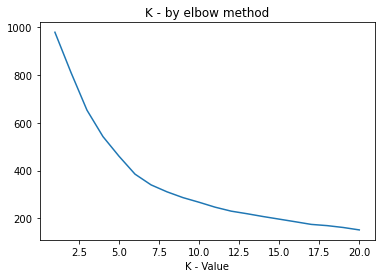

In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Ks = 20
acc = np.zeros(Ks)

for n in range(1,Ks+1):
    kmeans = KMeans(init = "k-means++", n_clusters=n, random_state=6).fit(to_clustering)
    acc[n-1] = kmeans.inertia_
    
plt.plot(range(1,Ks+1),acc)
plt.title('K - by elbow method')
plt.xlabel('K - Value')

Looking at the graph the k value of **6** looks optimal

**5.2 Finding clusters by K-Means**

In [59]:
kclusters = 6
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=6).fit(to_clustering)

to_grouped.insert(1,'Cluster Labels',kmeans.labels_)

to_grouped.groupby('Cluster Labels').mean()

Total Crime         Rent  Convenience  Culture and Community  \
Cluster Labels                                                                 
0               1284.763265  2079.418367     0.402792               0.122121   
1               1085.800000  2417.888889     0.167948               0.692829   
2               1304.528571  2612.275510     0.181470               0.151817   
3               1316.700000  2750.000000     0.000000               0.222222   
4               4527.020000  2729.333333     0.212000               0.138000   
5               1199.111111  2104.888889     0.258955               0.168825   

                Education  Socializing   Transit  
Cluster Labels                                    
0                0.000000     0.458487  0.016601  
1                0.013177     0.126047  0.000000  
2                0.000305     0.650608  0.014185  
3                0.222222     0.444444  0.111111  
4                0.010000     0.626000  0.014000  
5                0.000000     0.461577  0.110082

<!---
map = folium.Map(location=[43.721, -79.4], zoom_start=11)

# To circumvent the hood number in parenthesis in the geojson
to_data = crime_df.copy().drop("Total Crime",1)
to_data = to_data.merge(to_grouped[['Neighborhood','Cluster Labels']], on='Neighborhood',how='left')
l=[]

for i in js['features']:
    l.append(i['properties']['AREA_NAME'])
                                                
to_data.insert(1,"Neighborhood1",l)
to_data = to_data.drop("Neighborhood",1)


folium.Choropleth(
    geo_data=js,
    name='choropleth',
    data=to_data,
    columns=['Neighborhood1', 'Cluster Labels'],
    key_on='feature.properties.AREA_NAME',
    line_weight=0.5,
    fill_color='YlOrRd',
    line_color='black',
    fill_opacity=1.0,
    line_opacity=0.5,
    legend_name='Toronto City Neighborhood Clusters'

).add_to(map)

map
-->

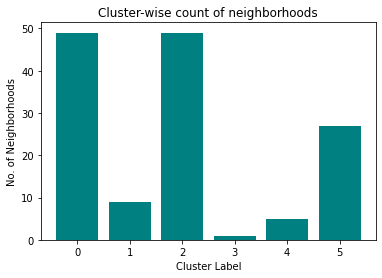

In [79]:
# Checking the size of each cluster
x = to_grouped.groupby('Cluster Labels').count().reset_index()['Cluster Labels']
y = to_grouped.groupby('Cluster Labels').count().reset_index()['Neighborhood']
plt.bar(x,y,color='teal')
plt.xlabel('Cluster Label')
plt.ylabel('No. of Neighborhoods')
plt.title('Cluster-wise count of neighborhoods')
plt.show()

**5.3 Creating a ranked table to better understand relative standings of the neighborhood clusters**

In [60]:
to_clusters = to_grouped.groupby('Cluster Labels').mean().reset_index()

# Creating ranked clusters
to_clusters_ranked = pd.DataFrame(columns = to_clusters.columns)
to_clusters_ranked['Cluster Labels'] = to_clusters['Cluster Labels']

# Crime and Rent --> Lower is better
for col in to_clusters.columns[1:3]:
    to_clusters_ranked[col] = to_clusters[col].rank(method = 'min', ascending=True)
    
# For other features --> Higher is better
for col in to_clusters.columns[3:]:
    to_clusters_ranked[col] = to_clusters[col].rank(method = 'min', ascending=False)
    
to_clusters_ranked

Cluster Labels  Total Crime  Rent  Convenience  Culture and Community  \
0               0          3.0   1.0          1.0                    6.0   
1               1          1.0   3.0          5.0                    1.0   
2               2          4.0   4.0          4.0                    4.0   
3               3          5.0   6.0          6.0                    2.0   
4               4          6.0   5.0          3.0                    5.0   
5               5          2.0   2.0          2.0                    3.0   

   Education  Socializing  Transit  
0        5.0          4.0      3.0  
1        2.0          6.0      6.0  
2        4.0          1.0      4.0  
3        1.0          5.0      1.0  
4        3.0          2.0      5.0  
5        5.0          3.0      2.0

**Comparing the clusters we can find the following patterns:**<br>

Cluster 0: Low Rent, High Convenience (Shops, Offices, Residences), Poor Transit and Dining options<br>
Cluster 1: Best Cultural activities (Community Centers, Parks, Events) and most safe<br>
Cluster 2: Best for Dining and Nightlife<br>
Cluster 3: Best for Educational institutes and transit/ stay options<br>
Cluster 4: Good for Dining/ Nightlife but mediocre/poor for everything else<br>
Cluster 5: Good for most parameters, well balanced<br>

**5.4 Visualizing the neighborhood clusters**

In [61]:
import branca.colormap as cmp

# Creating a qualitative color scheme
step = cmp.StepColormap(
 ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33'],
    vmin=0, vmax=5, #index=[0,1,2,3,4,5,6]
)

# To circumvent the neighborhood number in parenthesis in the geojson

to_data = crime_df.copy().drop("Total Crime",1)
to_data = to_data.merge(to_grouped[['Neighborhood','Cluster Labels']], on='Neighborhood',how='left')
l=[]

for i in js['features']:
    l.append(i['properties']['AREA_NAME'])
                                                
to_data.insert(1,"Neighborhood1",l)
to_data = to_data.drop("Neighborhood",1)

# Using folium geojson and choropleth geojson to create visualization

cluster_dict = to_data.set_index('Neighborhood1')['Cluster Labels']

m = folium.Map(location=[43.721, -79.4], zoom_start=11, tiles='CartoDB positron')


folium.GeoJson(
    js,
    style_function=lambda feature: {
        'fillColor': step(cluster_dict[feature['properties']['AREA_NAME']]),
        'fillOpacity': '0.8',
        'color': 'black',       
        'weight': 0.8,            
    }
).add_to(m)

choropleth = folium.Choropleth(
    geo_data=js,
    fill_color=None,
    fill_opacity=0.0,
    line_color=None,
    line_opacity=0.0
).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['AREA_NAME'], labels=False))

m

<span style="color:#e41a1c">**RED (Cluster 0)**</span>: Low Rent, High Convenience (Shops, Offices, Residences), Poor Transit and Dining options<br>
<span style="color:#377eb8">**BLUE (Cluster 1)**</span>: Best Cultural activities (Community Centers, Parks, Events) and most safe<br>
<span style="color:#4daf4a">**GREEN (Cluster 3)**</span>: Best for Dining and Nightlife<br>
<span style="color:#984ea3">**PURPLE (Cluster 4)**</span>: Best for Educational institutes and transit/ stay options<br>
<span style="color:#ff7f00">**ORANGE (Cluster 5)**</span>: Good for Dining/ Nightlife but mediocre/poor for everything else<br>
<span style="color:#ffff33">**YELLOW (Cluster 6)**</span>: Good for most parameters, well balanced<br>

---